In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.utils import resample 
import pandas as pd
import numpy as np
import os, random
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pickle 

In [14]:
train_cols = ["ZipCode",
              "doc acres",
              "building style code", 
              "building class code", 
              "quality code",
              "actual year built",
              "effective year built",
              "building heated area",
              "Number Of Bedrooms",
              "Number Of Bathrooms",
              "Number Of Rooms",
              "MedianIncome",
              "MilitaryServiceRate",
              "UnemploymentRate",
              "EducationLevel",
              "PovertyRate",
              "PctWhereRentIsMoreThan35PctOfIncome"]

meta_cols  = ["Parcel Number"]
ycol = "Assessed Value"

(array([4.20543262e-06, 1.99611180e-06, 3.55547105e-07, 9.63097413e-08,
        3.99468799e-08, 2.48028389e-08, 1.58595075e-08, 8.34710923e-09,
        6.16096158e-09, 4.17355462e-09, 3.49783625e-09, 1.66942185e-09,
        1.94765882e-09, 9.53955341e-10, 1.23219232e-09, 7.94962784e-10,
        5.56473949e-10, 3.57733253e-10, 4.37229531e-10, 2.78236974e-10,
        1.58992557e-10, 2.78236974e-10, 1.98740696e-10, 1.58992557e-10,
        0.00000000e+00, 1.19244418e-10, 0.00000000e+00, 0.00000000e+00,
        3.97481392e-11, 7.94962784e-11]),
 array([3.2120000e+03, 1.5102180e+05, 2.9883160e+05, 4.4664140e+05,
        5.9445120e+05, 7.4226100e+05, 8.9007080e+05, 1.0378806e+06,
        1.1856904e+06, 1.3335002e+06, 1.4813100e+06, 1.6291198e+06,
        1.7769296e+06, 1.9247394e+06, 2.0725492e+06, 2.2203590e+06,
        2.3681688e+06, 2.5159786e+06, 2.6637884e+06, 2.8115982e+06,
        2.9594080e+06, 3.1072178e+06, 3.2550276e+06, 3.4028374e+06,
        3.5506472e+06, 3.6984570e+06, 3.846266

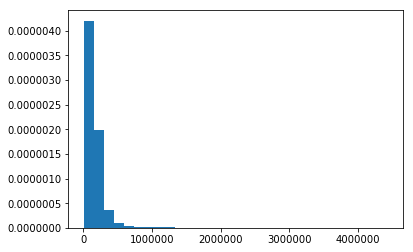

In [15]:
#read in the case table
fpath = os.path.join("data", "casetable.psv")
df = pd.read_csv(fpath, sep = "|", low_memory=False)
df_census = pd.read_csv(os.path.join("data", "census2017.csv"))

merged_df = pd.merge(df, df_census, left_on="Site Zip Code", right_on='ZipCode')

plt.hist(merged_df['Assessed Value'], density=True, bins=30)

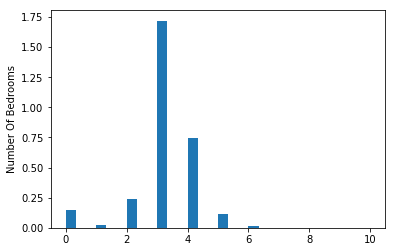

In [16]:
plt.ylabel('AssessedValue')

plt.hist(merged_df['Number Of Bedrooms'], density=True, bins=30)
plt.ylabel('Number Of Bedrooms')

merged_df = merged_df[merged_df[ycol]<1000000]
merged_df = merged_df[merged_df['Number Of Bedrooms']<10]
merged_df.fillna(-999,inplace = True)

y = merged_df[ycol]

#TODO: Specify the features of the model instead of dropping fields


In [17]:
def split(df, pct=.7):
    tr, xv = [], []
     
    indices = [x for x in df.index]
    random.shuffle(indices)
 
    for ind in indices:
        if np.random.rand() <= pct:
            tr.append(ind)
        else:
            xv.append(ind)
 
    return tr, xv

In [18]:
tr_indices, xv_indices = split(merged_df)

features_tr = merged_df.loc[tr_indices, train_cols]
features_xval = merged_df.loc[xv_indices, train_cols]
y_tr = y.loc[tr_indices]
y_xval = y.loc[xv_indices]

In [19]:
for col in train_cols:
    print(col, merged_df[col].unique())

ZipCode [32234 32219 32220 32221 32222 32218 32208 32225 32254 32205 32210 32244
 32257 32202 32209 32206 32204 32207 32217 32223 32226 32216 32277 32211
 32246 32256 32258 32224 32250 32081 32233 32266]
doc acres [1.82  1.21  0.    ... 0.025 1.264 1.375]
building style code [1 8 3]
building class code [4 3 2 5 1]
quality code [3 2 1 4 5 6]
actual year built [1980 1955 1941 1967 1989 1991 1996 2000 1939 1973 1985 1961 1974 1992
 2001 1968 1931 1983 1958 1975 1987 1953 1963 1998 1924 1966 1979 2008
 1969 2004 1960 1943 1952 1948 1921 1908 1926 1971 2006 1914 2015 2016
 2003 1984 1937 1981 1977 1962 1954 1949 1957 1930 1936 1942 1990 1972
 1944 1934 1946 2011 2005 1959 1925 1950 1964 1956 1965 1993 1999 1995
 1976 2007 1988 2013 1920 2002 2010 1994 2012 2009 1911 1922 1970 1945
 1986 1940 2018 1947 1951 1935 1978 2014 1982 2017 1909 1997 1933 1915
 1929 1932 1928 1896 1918 1927 1919 1923 1938 1910 1917 1902 1904 1916
 1905 1899 1913 1912 1901 1900 1907 1888 1906 1903 1884 1898 1887 1897


In [ ]:
#create split function
random.seed(19860406)
np.random.seed(19860406)

rfc = RandomForestRegressor(
        max_depth = 5, 
        n_estimators = 25, 
        min_samples_leaf = 15)

rfc.fit(features_tr, y_tr.values.ravel())

tr_yhat2 = rfc.predict(features_tr)
xval_yhat2 = rfc.predict(features_xval)

tr_MSE = metrics.mean_squared_error(y_tr, tr_yhat2)
xval_MSE = metrics.mean_squared_error(y_xval, xval_yhat2)

print('tr MSE {} xval MSE {}'.format(tr_MSE, xval_MSE))


In [ ]:
with open(os.path.join(".model", 'model.pckl'), 'wb') as f:
   pickle.dump(rfc, f,  pickle.HIGHEST_PROTOCOL)